# CCFDetector: Using ML against Credit Card Frauds

L'obiettivo di questo progetto, realizzato per l'esame di Fondamenti di Intelligenza Artificiale presso l'Univeristà degli Studi di Salerno, è quello di realizzare un sistema di Machine Learning per l'individuazione di transazioni fraudolente relative ai pagamenti elettronici, cioè tutte quelle transazioni effettuate da carte di credito senza l'autorizzazione dei possessori .
## Setup del progetto e Data Understanding
---
### Inizio ad importare le librerie necessarie

In [56]:
# import the necessary packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec
import plotly.express as px

### Carico il dataset
Il dataset contiene più di 20 milioni di righe, dunque, per motivi legati alla capacità dell'hardware, ne andrò a selezionare 300.000.

In [57]:
df = pd.read_csv('credit_card_transactions-ibm_v2.csv').sample(n=300000, random_state=42)
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,No
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,No
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,No
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,No
792843,55,3,2006,6,10,09:15,$1.36,Swipe Transaction,-6571010470072147219,Rego Park,NY,11374.0,5499,NaN,No
8966297,776,0,2007,2,25,22:31,$97.81,Swipe Transaction,-6974082828836151610,Milwaukee,WI,53224.0,4900,NaN,No
895801,66,0,2007,8,21,13:02,$23.25,Swipe Transaction,3675785629314646441,Gonzales,TX,78629.0,7349,NaN,No
22902727,1880,2,2010,12,31,01:06,$486.70,Swipe Transaction,-3398248499422470718,Atlantic City,NJ,8401.0,7995,NaN,No
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,No


In [58]:
# Controllo che siano state importate anche transazioni fraudolente
df[df['Is Fraud?'] == 'Yes'].shape

(388, 15)

### Descrizione del dataset


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 18199893 to 18106096
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            300000 non-null  int64  
 1   Card            300000 non-null  int64  
 2   Year            300000 non-null  int64  
 3   Month           300000 non-null  int64  
 4   Day             300000 non-null  int64  
 5   Time            300000 non-null  object 
 6   Amount          300000 non-null  object 
 7   Use Chip        300000 non-null  object 
 8   Merchant Name   300000 non-null  int64  
 9   Merchant City   300000 non-null  object 
 10  Merchant State  266377 non-null  object 
 11  Zip             264443 non-null  float64
 12  MCC             300000 non-null  int64  
 13  Errors?         4778 non-null    object 
 14  Is Fraud?       300000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 36.6+ MB


Come si può osservare, le caratteristiche *Merchant State*, *Zip* ed *Errors?* contengono dei valori nulli. Vado a generare un istogramma per la visualizzazione della percentuale di valori nulli per ciascun attributo. 

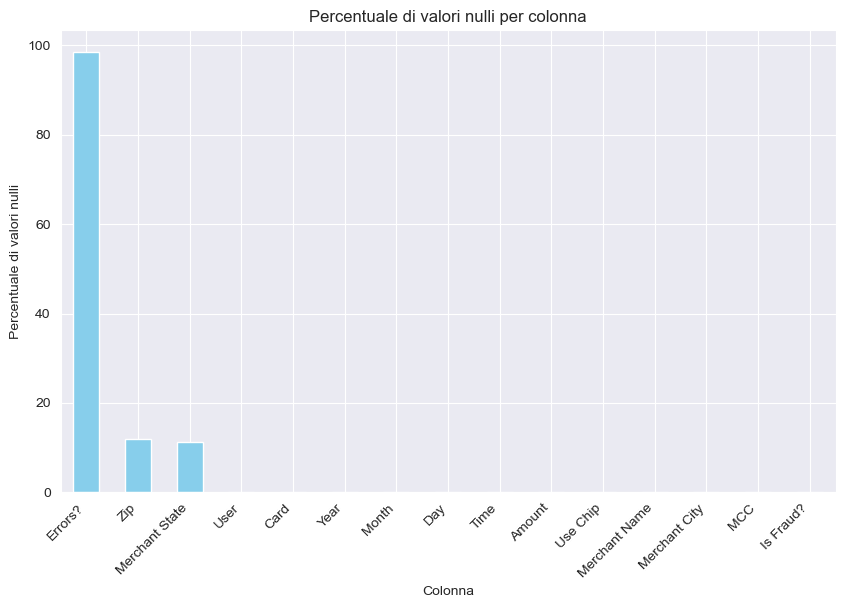

In [60]:
# Calcolo percentuale di valori nulli per ogni colonna
percent_missing = (df.isnull().sum() / len(df)) * 100

# Ordino in ordine decrescente di percentuale
sorted_columns = percent_missing.sort_values(ascending=False)

# Creo un istogramma
plt.figure(figsize=(10, 6))
sorted_columns.plot(kind='bar', color='skyblue')
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('Colonna')
plt.ylabel('Percentuale di valori nulli')
plt.xticks(rotation=45, ha='right')
plt.show()

La variabile target, dunque quella che il modello dovrà predire, è rappresentata dalla colonna **Is Fraud?**, contenente valori non interi. Dunque, prima di proseguire, per questioni di praticità, vado a creare una nuova colonna chiamata **Fraud**, nella quale mapperò i valori della colonna originale che hanno valore 'Yes' a 1 e quelli che hanno valore 'No' a 0. Infine, rimuovo la colonna originale.

In [61]:
# Creo una nuova colonna 'Fraud' e le assegno i valori di 'Is Fraud?' convertiti in 0 e 1
df['Fraud'] = df['Is Fraud?'].map({'Yes': 1, 'No': 0})

# Elimina la colonna 'Is Fraud?'
df.drop(['Is Fraud?'], axis=1, inplace=True)
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Fraud
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,0
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,0
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,0
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,0
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,0
792843,55,3,2006,6,10,09:15,$1.36,Swipe Transaction,-6571010470072147219,Rego Park,NY,11374.0,5499,NaN,0
8966297,776,0,2007,2,25,22:31,$97.81,Swipe Transaction,-6974082828836151610,Milwaukee,WI,53224.0,4900,NaN,0
895801,66,0,2007,8,21,13:02,$23.25,Swipe Transaction,3675785629314646441,Gonzales,TX,78629.0,7349,NaN,0
22902727,1880,2,2010,12,31,01:06,$486.70,Swipe Transaction,-3398248499422470718,Atlantic City,NJ,8401.0,7995,NaN,0
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,0


A questo punto passo a verificare se il dataset è sbilanciato, oppure no.


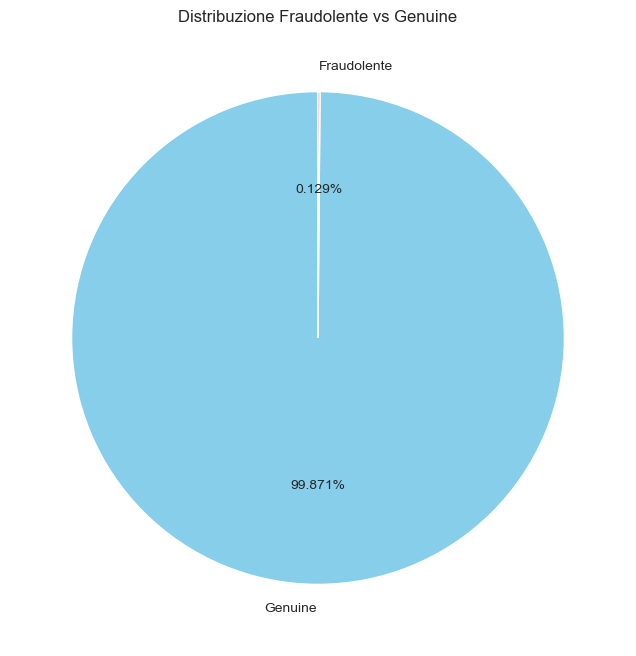

In [62]:
fraud_counts = df['Fraud'].value_counts()

# Crea un grafico a torta
plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=['Genuine', 'Fraudolente'], autopct=lambda p: '{:.3f}%'.format(p), colors=['skyblue', 'salmon'], startangle=90)
plt.title('Distribuzione Fraudolente vs Genuine')
plt.show()

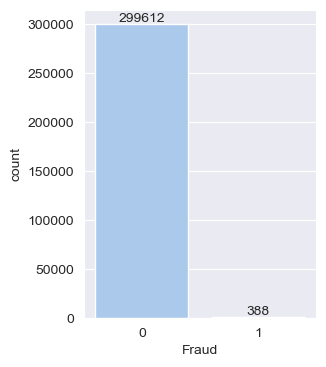

In [63]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Fraud',data=df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

Come mostrano i grafici appena riportati, il dataset si mostra estremamente sbilanciato, con solo lo 0,129% delle transazioni che risultano essere fraudolente: 388 casi di frode contro le 299612 transazioni autorizzate.

## Data Preparation
---
### Data Cleaning
A questo punto, sulla base delle osservazioni fatte in fase di Data Understanding, procedo con la pulizia del dataset.
Innanzitutto, verifico quali sono i valori unici presenti nella colonna *Errors?*.

In [64]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance',
       'Bad Card Number,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad Card Number,Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance'],
      dtype=object)

Studiando l'output del metodo unique(), noto che questa tabella riporta le varie tipologie di errore verificatesi nelle varie transazioni. Se non si verifca alcun errore, il valore risulta essere nullo. Dunque posso procedere alla sostituzione dei valori nulli con un valore che indica che non si sono verificati errori (dunque la transazione ha avuto esito positivo).

In [65]:
df["Errors?"]= df["Errors?"].fillna("No error")

In [66]:
# Controllo l'esito dell'operazione
error_null_values = df["Errors?"].isnull().sum()
print('Nuovo numero di valori nulli: ', error_null_values)

Nuovo numero di valori nulli:  0


A questo punto vado a rimuovere le colonne *Merchant State* e *Zip* in quanto contengono valori nulli e, ad ogni modo, possono essere ricavate dalla caratteristica *Merchant City*.

In [67]:
df.drop(['Merchant State', 'Zip'], axis=1, inplace=True)

Osservo quali valori puo' assumere la caratteristica *Use Chip*:

In [68]:
df["Use Chip"].unique()

array(['Chip Transaction', 'Online Transaction', 'Swipe Transaction'],
      dtype=object)

I dati *Time* ed *Amount* non sono in formato numerico, dunque, affinche' possa lavorarci e studiarli, devo convertirli in formato numerico.
Nel caso di Amount, basta andare a rimuovere il simbolo della valuta anteposto alle cifre e poi convertire in float:

In [69]:
# Rimuovo simbolo del dollaro e converto i valori di Amount in float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [70]:
# Controllo il risultato della modifica
df["Amount"].info()

<class 'pandas.core.series.Series'>
Index: 300000 entries, 18199893 to 18106096
Series name: Amount
Non-Null Count   Dtype  
--------------   -----  
300000 non-null  float64
dtypes: float64(1)
memory usage: 4.6 MB


Per quanto riguarda Time, invece, siccome non posso convertirlo in un intero, decido di scomporlo in ora e minuto:

In [71]:
# Divido Time in Hour e Minute
df["Hour"] = df["Time"].str[0:2] # Prendo prime due cifre
df["Minute"] = df["Time"].str[3:5] # Prendo ultime due cifre
df.drop(['Time'], axis=1, inplace=True)
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Fraud,Hour,Minute
18199893,1470,0,2019,7,10,59.18,Chip Transaction,-6853385250336487907,Harwood,5813,No error,0,00,11
9731325,822,1,2019,1,14,280.91,Online Transaction,4241336128694185533,ONLINE,4814,No error,0,22,12
536687,41,3,2010,3,15,-144.00,Swipe Transaction,190253443608377572,Hemet,3359,No error,0,07,07
13223840,1084,0,2015,9,20,6.76,Chip Transaction,-7837310524365334241,Littleton,5300,No error,0,14,58
17070521,1384,0,2014,10,12,9.17,Swipe Transaction,-5023497618971072366,Gardner,5812,No error,0,11,44
